**BASIC**

In [637]:
import os
#import gym
#import math
#import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#import datetime
#from dateutil.relativedelta import relativedelta   #for leaping forward by 1 year
#from collections import namedtuple, deque
from itertools import count
#from statsmodels.tsa.stattools import coint, adfuller
#from statsmodels.regression.linear_model import OLS

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from stock_trading_environment import StockTradingEnvironment, Positions

import dqn
from dqn import ReplayMemory, DQN

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

In [39]:
#function for saving trained models in a folder
def uniquify(path):
    filename, extension = os.path.splitext(path)
    counter = 1

    while os.path.exists(path):
        path = filename + " (" + str(counter) + ")" + extension
        counter += 1

    return path

In [ ]:
#autoreload modified modules
%load_ext autoreload
%autoreload 2

**DATA PIPELINE**

In [61]:
import data_pipeline as pipeline
import config
pgConnStr = config.pgDictToConn(config.pgSecrets)

In [62]:
dailyDF = pipeline.getDailyPrices(pipeline.getDailyPricesTickersLst(pgConnStr), pgConnStr)

In [67]:
n_clusters = 10

In [68]:
clusters = pipeline.findStockClusters(dailyDF, n_clusters)

/Users/thomaskho/Documents/MADS/Capstone/testvenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [69]:
good_clusters_dict = pipeline.findStocksinClusters(clusters, n_clusters)

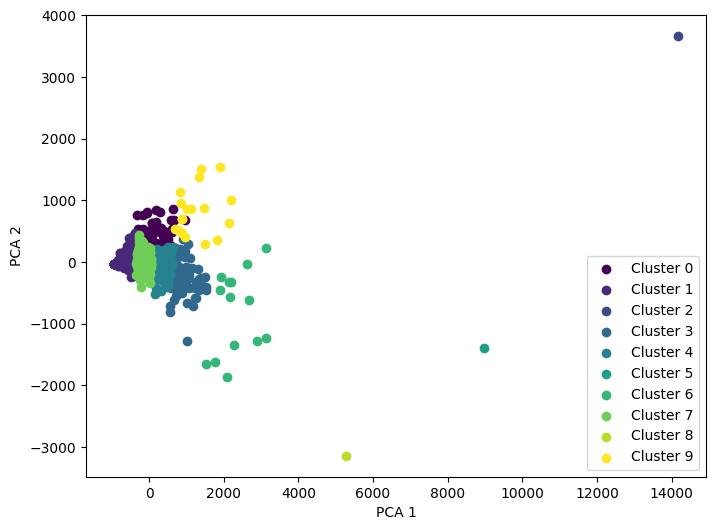

In [70]:
pipeline.plotStockClusters(clusters)

In [49]:
'''
Data pipeline:
    - Read filtered stocks closing prices as CSV/in SQL
    - Find clusters with kmeans and PCA
    - Filter out some outlier clusters; key clusters # as a dict
    - Find cointegration of each key cluster and plot heatmap
'''
import data_pipeline as pipeline
import config

pgConnStr = config.pgDictToConn(config.pgSecrets)

n_clusters = 10
#dailyDF = pd.read_csv('./data/dailyDF', header=0)#, index_col=0, skiprows=0)
dailyDF = pipeline.getDailyPrices(pipeline.getDailyPricesTickersLst(pgConnStr), pgConnStr)
clusters = pipeline.findStockClusters(dailyDF, n_clusters)
good_clusters_dict = pipeline.findStocksinClusters(clusters, n_clusters)
pipeline.plotStockClusters(clusters)

KeyboardInterrupt: 

In [71]:
#just to check how many stocks in each cluster
for i in good_clusters_dict.keys():
    print(f'cluster {i}: {len(dailyDF[good_clusters_dict[i]].columns)} stocks')

cluster 0: 59 stocks
cluster 1: 344 stocks
cluster 3: 80 stocks
cluster 4: 222 stocks
cluster 6: 14 stocks
cluster 7: 352 stocks
cluster 9: 18 stocks


In [534]:
#split train/test data by time: 70/30#
#trainpairs, trainpval, traindf = pipeline.cointHeatmap(dailyDF[good_clusters_dict[9]].loc[:round(len(dailyDF)*0.7)].dropna(axis=1, how='all'))

#choose cluster of a reasonable size
dailyDF_train = dailyDF[good_clusters_dict[3]]

train_startdate = dailyDF_train.index[0]
train_enddate = train_startdate + pd.DateOffset(years=5)
trainpairs, trainpval, traindf = pipeline.cointHeatmap(dailyDF_train.loc[train_startdate:train_enddate].dropna(axis=1, how='all'))

[autoreload of DQN failed: Traceback (most recent call last):
  File "/Users/thomaskho/Documents/MADS/Capstone/testvenv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/Users/thomaskho/Documents/MADS/Capstone/testvenv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/Users/thomaskho/miniforge3/lib/python3.9/importlib/__init__.py", line 168, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'DQN'
]


KeyboardInterrupt: 

In [541]:
trainpairs

[('ANIK', 'MATV'),
 ('PWOD', 'SCSC'),
 ('BBU', 'SKYW'),
 ('BBU', 'FSFG'),
 ('AGIO', 'PRG'),
 ('AGIO', 'AVNS'),
 ('AGIO', 'HURC'),
 ('AGIO', 'FMBH'),
 ('FMAO', 'OM'),
 ('NOAH', 'HURC'),
 ('EGRX', 'MATV'),
 ('EGRX', 'FMBH'),
 ('AVNS', 'HURC'),
 ('AVNS', 'NTB'),
 ('AVNS', 'FMBH'),
 ('SHEN', 'AUBN'),
 ('SHEN', 'ATEX'),
 ('SHEN', 'FCAP'),
 ('EBIX', 'TSE'),
 ('TSE', 'KYMR'),
 ('HURC', 'OFIX'),
 ('HURC', 'FMBH')]

In [542]:
len(trainpairs)

22

In [108]:
trainpval.shape

(50, 50)

In [109]:
###create trainenvs###
window_size = 60
trade_period = 5
transaction_cost = 0.05

trainenvs = []
for trainpair in trainpairs:
    traindata = traindf[list(trainpair)].dropna()
    if traindata.shape[0] > 450:
        trainenvs.append(StockTradingEnvironment(traindata.copy(), window_size, trade_period, transaction_cost))   #instantiate an env; automatatically run trade()


In [543]:
len(trainenvs)

19

[('PFC', 'NTB'), ('PFC', 'BMRC'), ('NTGR', 'SHEN'), ('PRO', 'STRT'), ('PRO', 'AUBN'), ('PRO', 'MATV'), ('SASR', 'ATEX'), ('SASR', 'HNI'), ('UNB', 'SATS'), ('UNB', 'ATEX'), ('UNB', 'HNI'), ('UNB', 'HURC'), ('KAMN', 'STRT'), ('KAMN', 'AUBN'), ('FMBH', 'HNI'), ('CEVA', 'AUBN'), ('KF', 'SNCY'), ('DLX', 'SNCY'), ('DLX', 'BIG'), ('JRVR', 'MATV'), ('STRT', 'AUBN'), ('STRT', 'RMAX'), ('SATS', 'ATEX')]


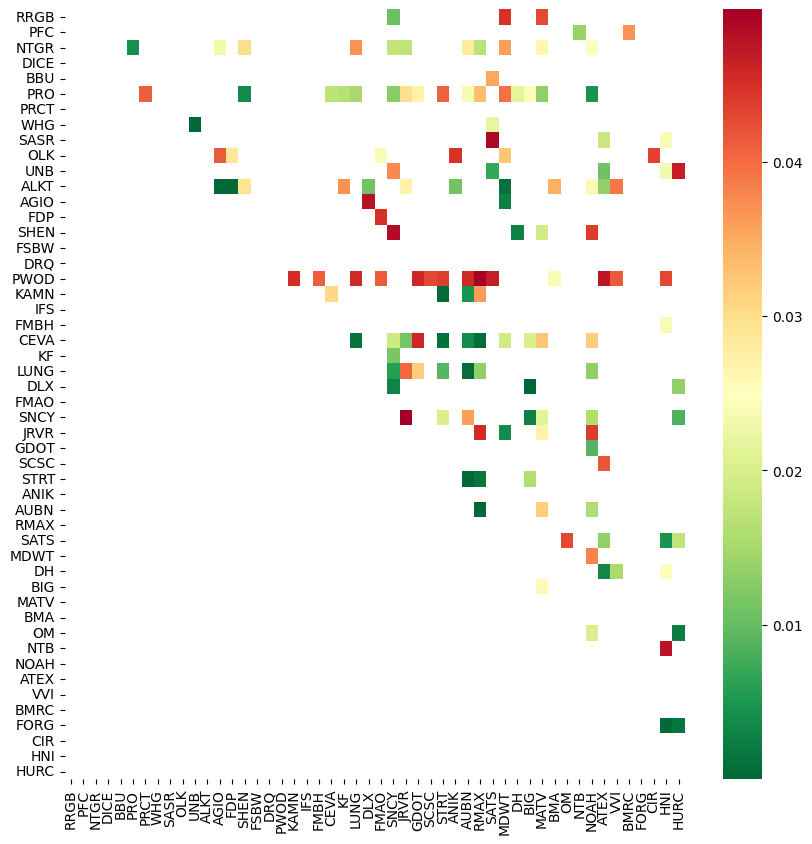

In [111]:
###val set heatmap###
#Remember to use the same cluster as train set
#valpairs, valpval, valdf = pipeline.cointHeatmap(dailyDF[good_clusters_dict[9]].loc[round(len(dailyDF)*0.7):].dropna(axis=1, how='all'))

valpairs, valpval, valdf = pipeline.cointHeatmap(dailyDF_train.loc[train_enddate:].dropna(axis=1, how='all'))

In [112]:
len(valpairs)

23

In [115]:
###create valenvs###
valenvs = []
for valpair in valpairs:
    valdata = valdf[list(valpair)].dropna()
    if valdata.shape[0] > 250:
        valenvs.append(StockTradingEnvironment(valdata.copy(), window_size, trade_period, transaction_cost))   #instantiate an env; automatatically run trade()

In [582]:
len(valenvs)

23

In [586]:
len(valdf)

849

**DEEP Q-NETWORK**

**Hyperparameters to tune**
1. Larger memory: 64000 - no visible improvement
2. lr: 1e-2 (R&R = 0, not sensitve at all), 1e-6 (show improving trend but R&R still negative)
3. activation function at output layer: Softmax can get to +ve return but reward still -ve; Sigmoid: +ve R&R! Record high scores!
4. different loss function: MSELoss terrible; L1Loss not impressive; BCELoss record scores! but seems unstable
5. GAMMA, TARGET_UPDATE
6. [more layers]
7. [increase batch size]

In [638]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
#EPS_DECAY = 200
EPS_DECAY = 500
TARGET_UPDATE = 5

# Get number of actions from gym action space
#n_actions = 3
n_actions = 2   #only trade or not_trade

policy_net = DQN(window_size + 2, n_actions, device).to(device)   #input size depends on length of status/obs; here window_size=60=past 60 zscores
target_net = DQN(window_size + 2, n_actions, device).to(device)
target_net.load_state_dict(policy_net.state_dict())   #target_net loads state_dict of policy_net
target_net.eval()   #set target_net to evaluate mode

#optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-4)   #from torch.optim; RMSprop = optimizer like SGD or Adam
optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-6)   #from torch.optim; RMSprop = optimizer like SGD or Adam
#memory = ReplayMemory(10000)
memory = ReplayMemory(127000)

In [639]:
###training agent###
num_episodes = 300
best_rewards = 0
steps_done = 0

#empty dicts to collect train/test rewards/returns
train_reward_dict = {}
train_return_dict = {}
val_reward_dict = {}
val_return_dict = {}


for i_episode in range(num_episodes):
    policy_net.train()   #sets mode to training mode
    train_rewards = []
    train_returns = []

    #initialize train_reward_dict and train_return_dict for this
    train_reward_dict[i_episode] = []
    train_return_dict[i_episode] = []
    val_reward_dict[i_episode] = []
    val_return_dict[i_episode] = []

    #initialize nn_counter for this episode
    nn_counter = 0
    
    for trainenv in trainenvs:
    #for env in [testinst]:
        # Initialize the environment and state
        obs = trainenv.reset()   #reset() will get (zscore, [self._position.value, self.pvalue])
        state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
        
        for t in count():   #keep looping until done -> break
            # Select and perform an action and return whether this action is returned by policy_network
            action, nn_count = DQN.select_action(state, EPS_START, EPS_END, EPS_DECAY, steps_done, policy_net, n_actions, device)   #epsilon-greedy: exploit or explore; state is this state
            #obs, reward, done, info = trainenv.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            obs, step_reward, done, info, step_return = trainenv.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            #reward is step_reward for this step
            #obs, reward, done = env.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            
            #append reward and return of this episode in the list
            train_reward_dict[i_episode].append(step_reward)
            train_return_dict[i_episode].append(step_return)
            
            step_reward = torch.tensor([step_reward], dtype=torch.float, device=device)
            step_return = torch.tensor([step_return], dtype=torch.float, device=device)

            # Observe new state
            if not done:
                next_state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            else:
                next_state = None

            # Store the transition in memory
            #current state status, action, next state status, reward
            #each state means 60 past zscores + current action + pvalue
            #each memory pushes 62 + 62 + 3 = 127 
            memory.push(state, action, next_state, step_reward)

            # Move to the next state
            state = next_state

            #tick steps_done to trigger epsilon-greedy
            steps_done += 1
            nn_counter += nn_count

            #new
            #train_rewards.append(reward)

            # Perform one step of the optimization (on the policy network)
            DQN.optimize_model(memory, BATCH_SIZE, device, policy_net, target_net, GAMMA, optimizer)   #optimize policy network with back propagation
            if done:
                train_rewards.append(info['total_reward'])
                train_returns.append(info['total_return'])
                break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:   #update target network every 5 episodes
        target_net.load_state_dict(policy_net.state_dict())   #update target network with policy network parameters
    
    # Validation
    policy_net.eval()   #validate, so set policy network at eval mode
    val_rewards = []
    val_returns = []
    with torch.no_grad():
        for valenv in valenvs:
            
            obs = valenv.reset()
            state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            for t in count():   #keep looping until done -> break
                # Select and perform an action
                action = policy_net(state).max(1)[1].view(1, 1)   #action returned by policy_net given state
                obs, step_reward, done, info, step_return = valenv.step(Positions(action.item()))   #take a step based on action returned by nn
                #obs, reward, done = env.step(Positions(action.item()))   #take a step based on action returned by nn
                state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)

                #new
                #test_rewards.append(reward)

                #append reward and return of this episode in the list
                val_reward_dict[i_episode].append(step_reward)
                val_return_dict[i_episode].append(step_return)

                if done:
                    val_rewards.append(info['total_reward'])
                    val_returns.append(info['total_return'])
                    break

    avg_rewards = np.mean(val_rewards)
    if avg_rewards > best_rewards:
        best_rewards = avg_rewards
        torch.save(policy_net.state_dict(), uniquify('./models/model.pth'))   #save trained model (policy_net) as a state_dict for future use

    print('epoch [{}/{}], train rewards:{:.4f}, returns:{:.4f}, val rewards:{:.4f}, returns:{:.4f}, policy_nn_actions:{:.4f}, training steps:{:.4f}'.format
          (i_episode + 1, num_episodes, np.mean(train_rewards), np.mean(train_returns), np.mean(val_rewards),
           np.mean(val_returns), nn_counter, len(train_reward_dict[i_episode])))

print('Complete')

epoch [1/300], train rewards:-60.3637, returns:-28.4306, val rewards:-2.7940, returns:-0.3868, policy_nn_actions:29731.0000, training steps:31756.0000
epoch [2/300], train rewards:-50.6504, returns:-21.3726, val rewards:-3.0304, returns:-0.9493, policy_nn_actions:30192.0000, training steps:31756.0000
epoch [3/300], train rewards:-32.9830, returns:-8.2070, val rewards:-1.5944, returns:0.1860, policy_nn_actions:30158.0000, training steps:31756.0000
epoch [4/300], train rewards:-35.4642, returns:-12.6156, val rewards:-0.7852, returns:0.9332, policy_nn_actions:30154.0000, training steps:31756.0000
epoch [5/300], train rewards:-25.0168, returns:-3.3727, val rewards:0.3051, returns:2.0607, policy_nn_actions:30170.0000, training steps:31756.0000
epoch [6/300], train rewards:-23.2095, returns:-2.7449, val rewards:1.0863, returns:3.0468, policy_nn_actions:30214.0000, training steps:31756.0000
epoch [7/300], train rewards:-26.8196, returns:-7.6984, val rewards:2.1808, returns:4.1538, policy_nn_a

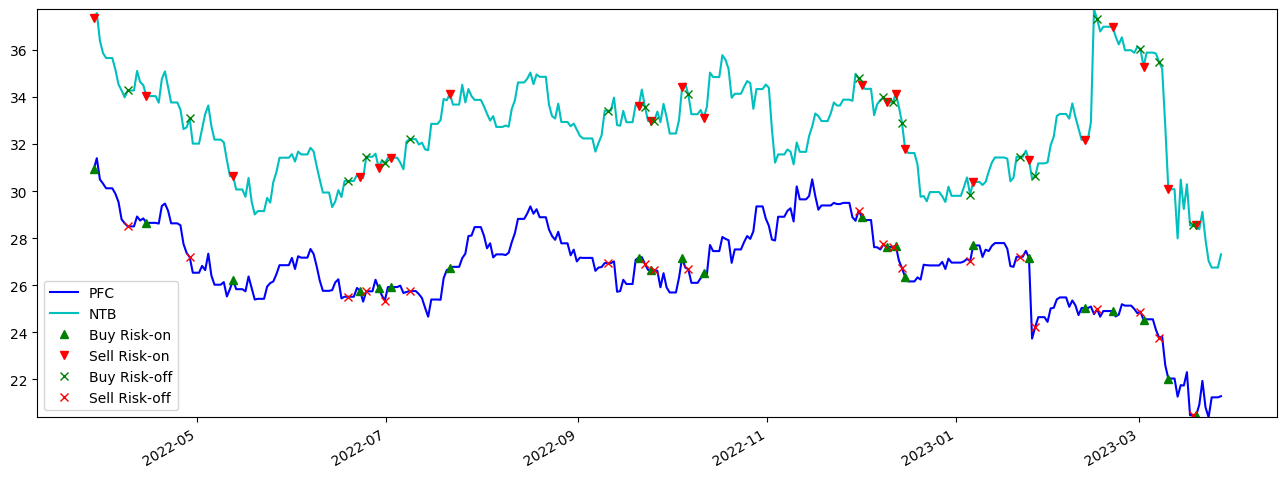

Total reward for this pair: -14.633847292224727
Total return for this pair: -12.49155654858129


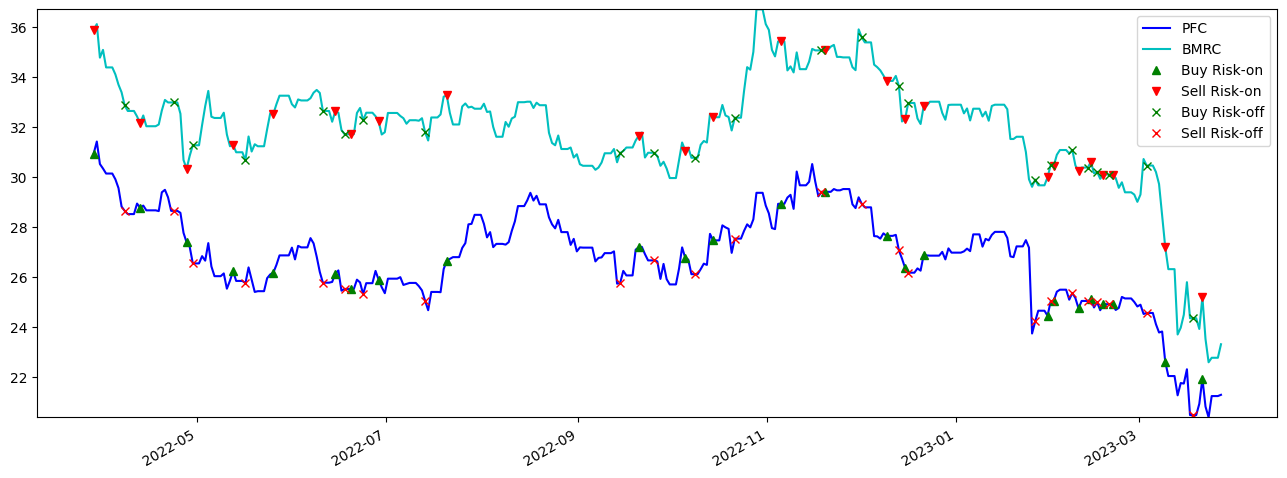

Total reward for this pair: -9.505310920497774
Total return for this pair: -8.174681566324624


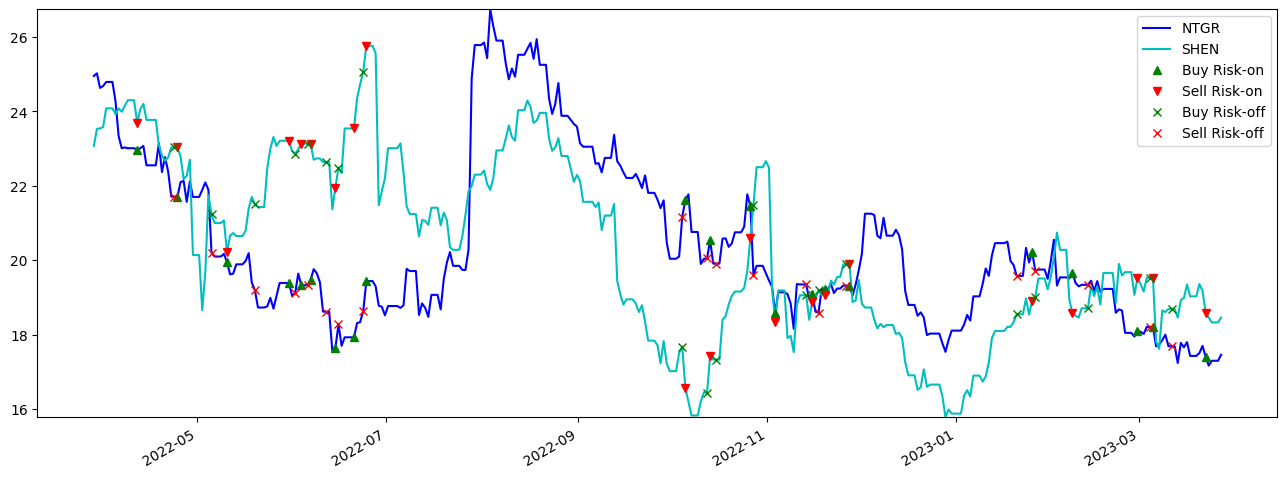

Total reward for this pair: -2.5738279047425148
Total return for this pair: -0.1169697754927056


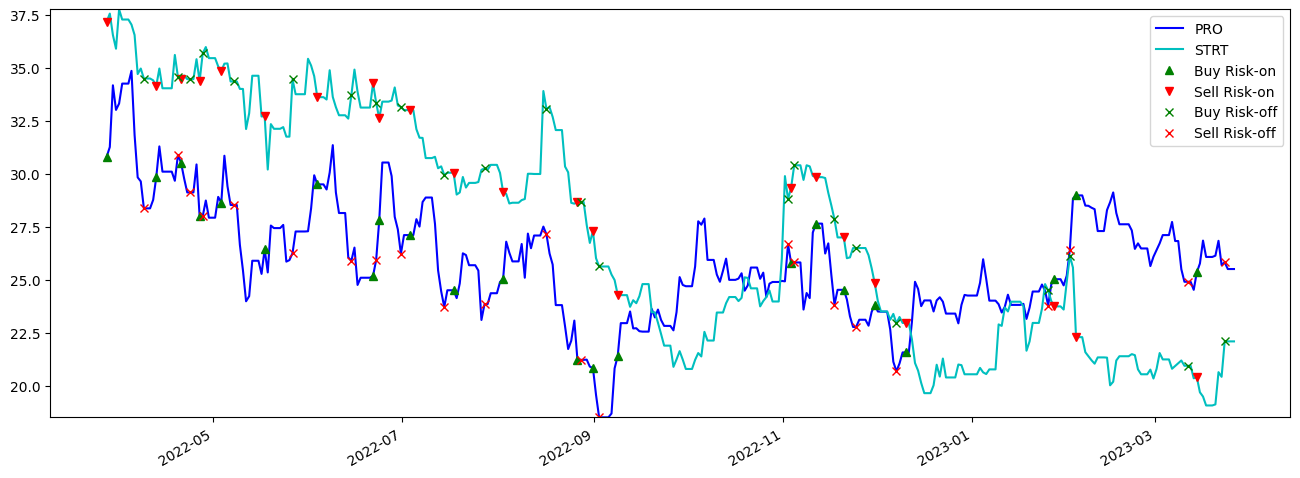

Total reward for this pair: -31.716527059823495
Total return for this pair: -28.52305643624734


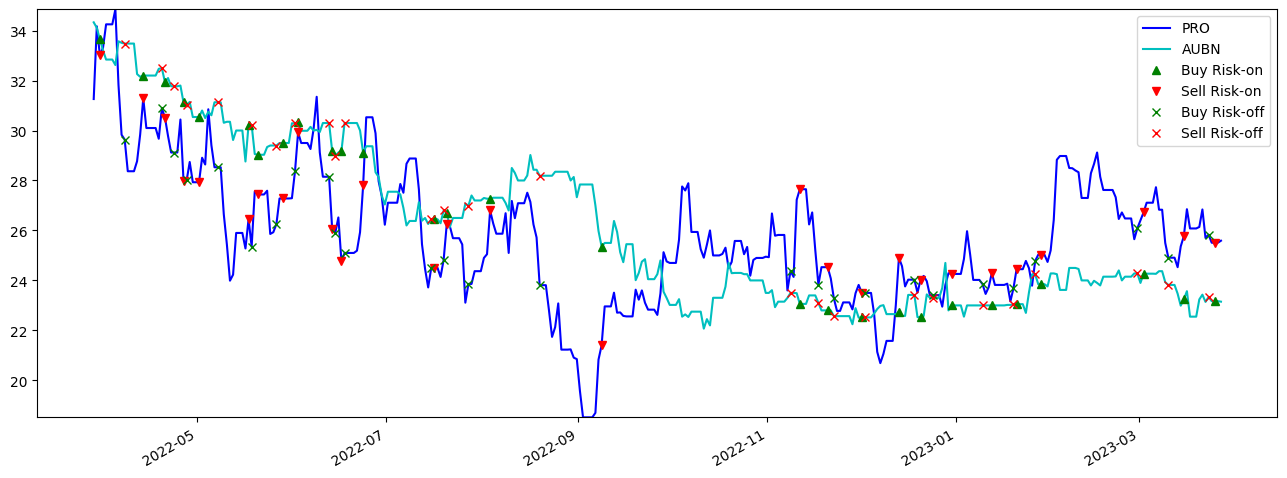

Total reward for this pair: 21.289267449571664
Total return for this pair: 23.790917346217945


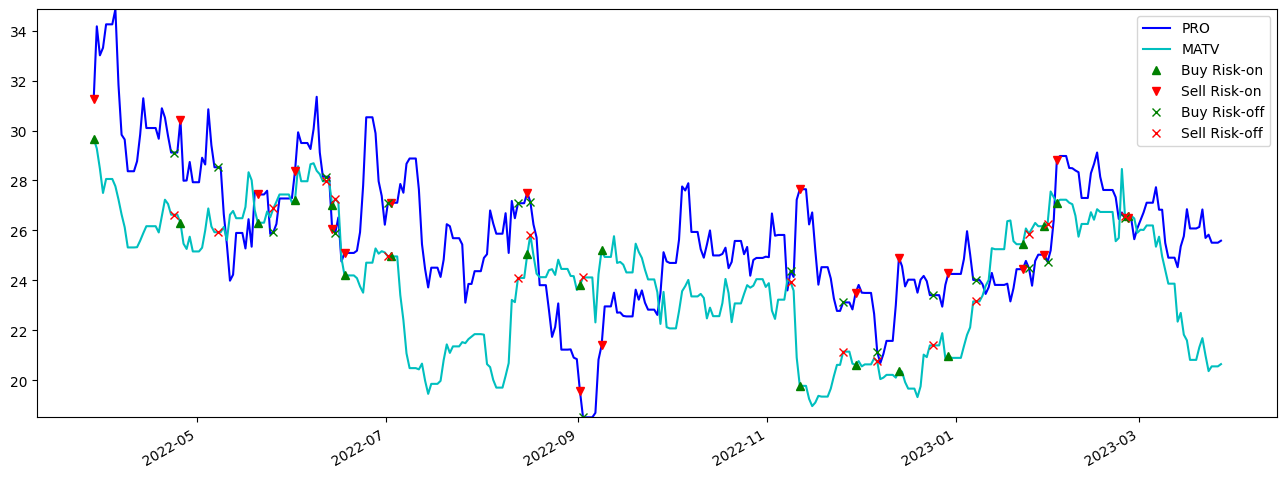

Total reward for this pair: 3.564139964832829
Total return for this pair: 5.632738661616904


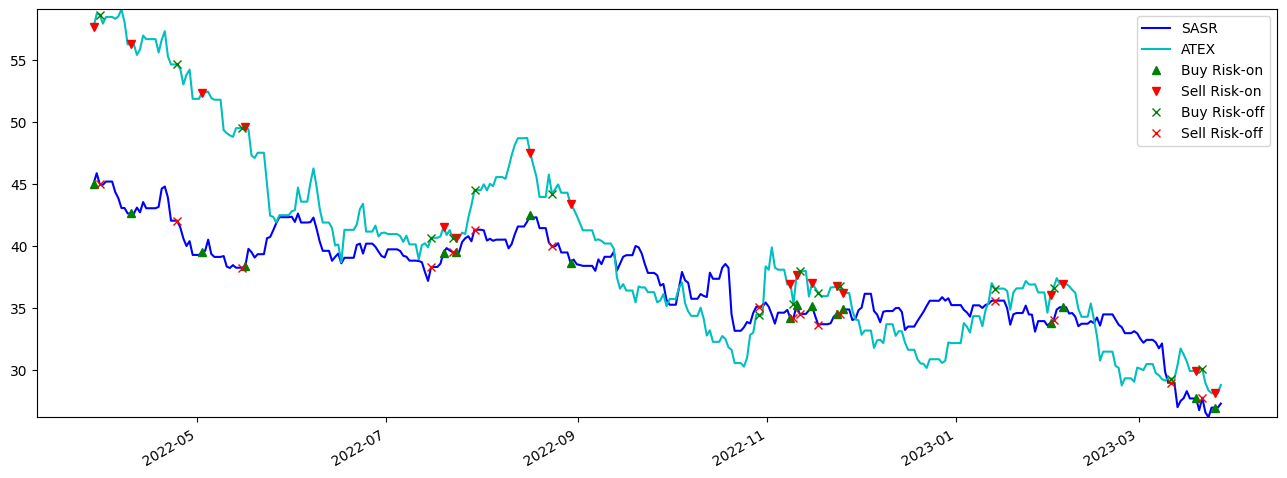

Total reward for this pair: 4.689366196479396
Total return for this pair: 7.118089563182294


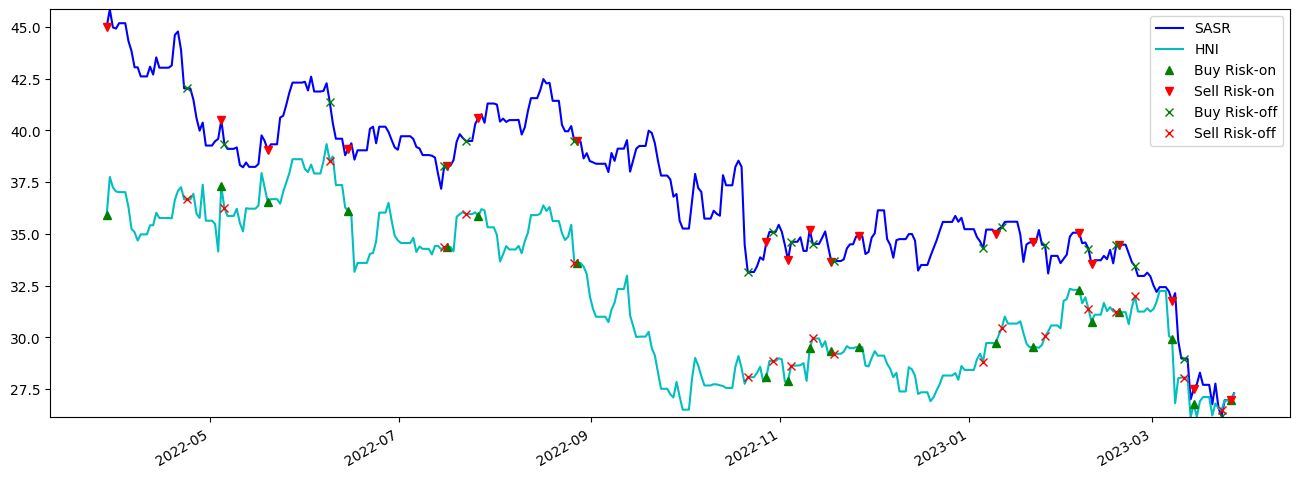

Total reward for this pair: -4.664349862268866
Total return for this pair: -2.7722564623449317


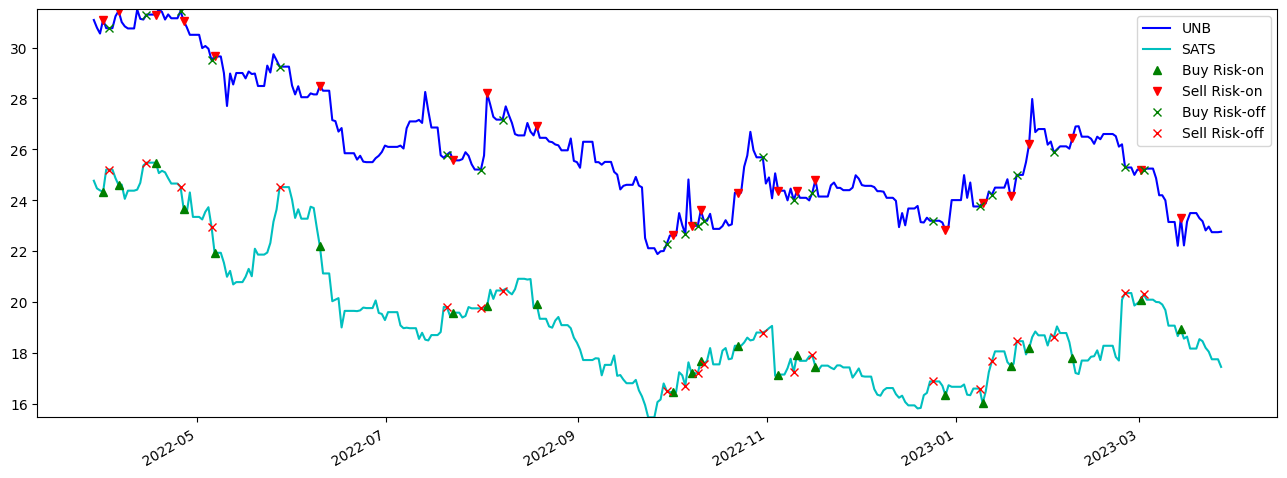

Total reward for this pair: 13.130473657235616
Total return for this pair: 14.786828032384246


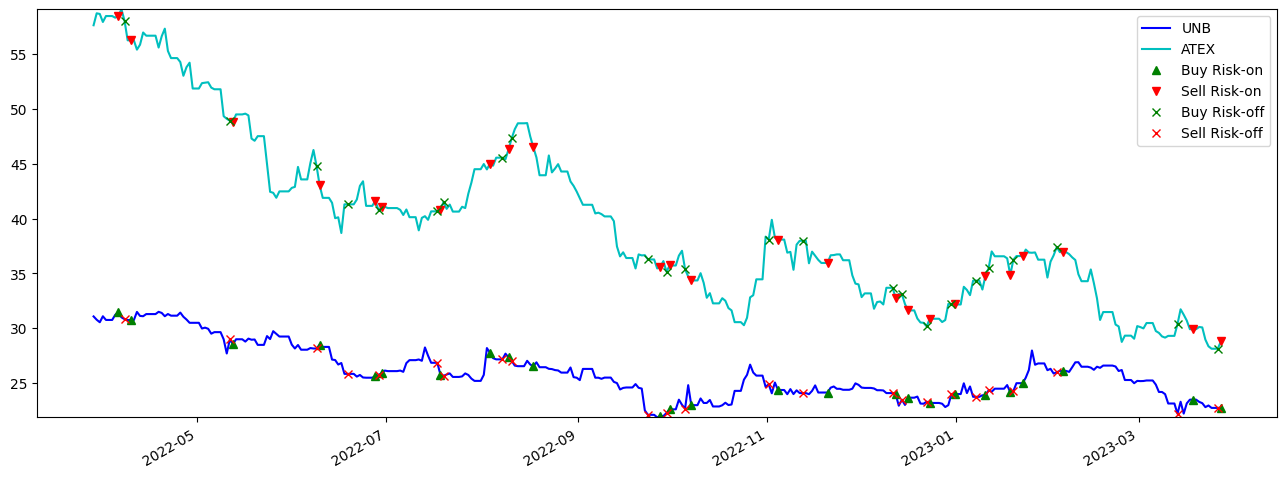

Total reward for this pair: -13.246077937584044
Total return for this pair: -10.606014533122302


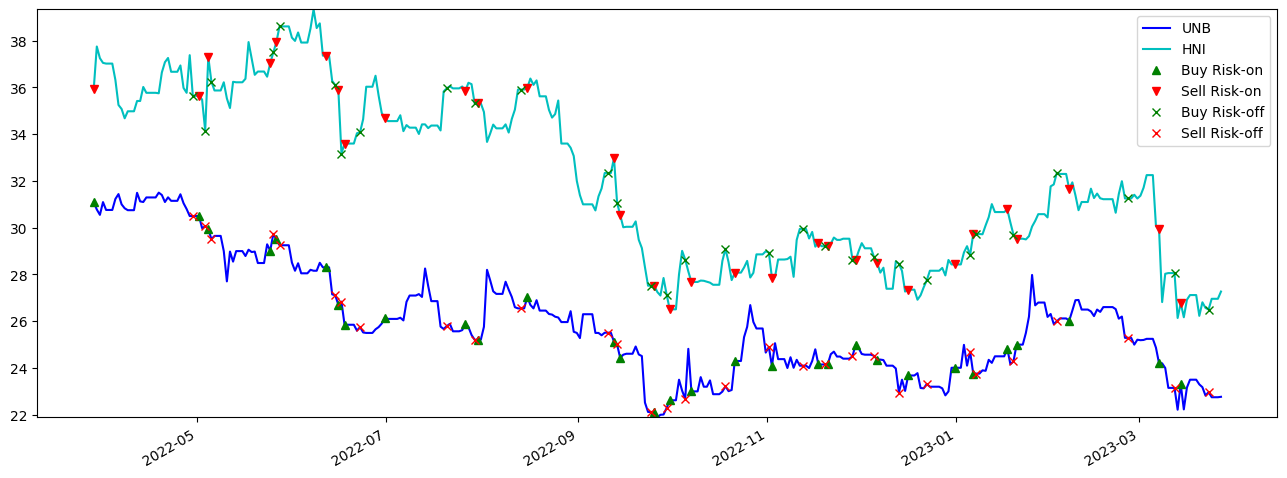

Total reward for this pair: -6.079466761258392
Total return for this pair: -3.6593501226847094


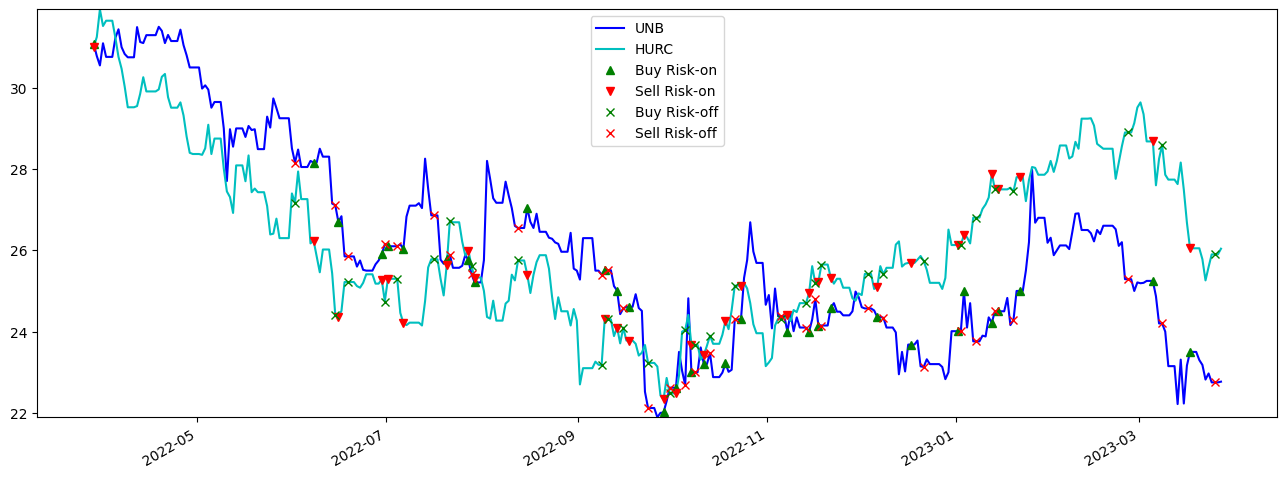

Total reward for this pair: -15.352291091925075
Total return for this pair: -12.832416603768817


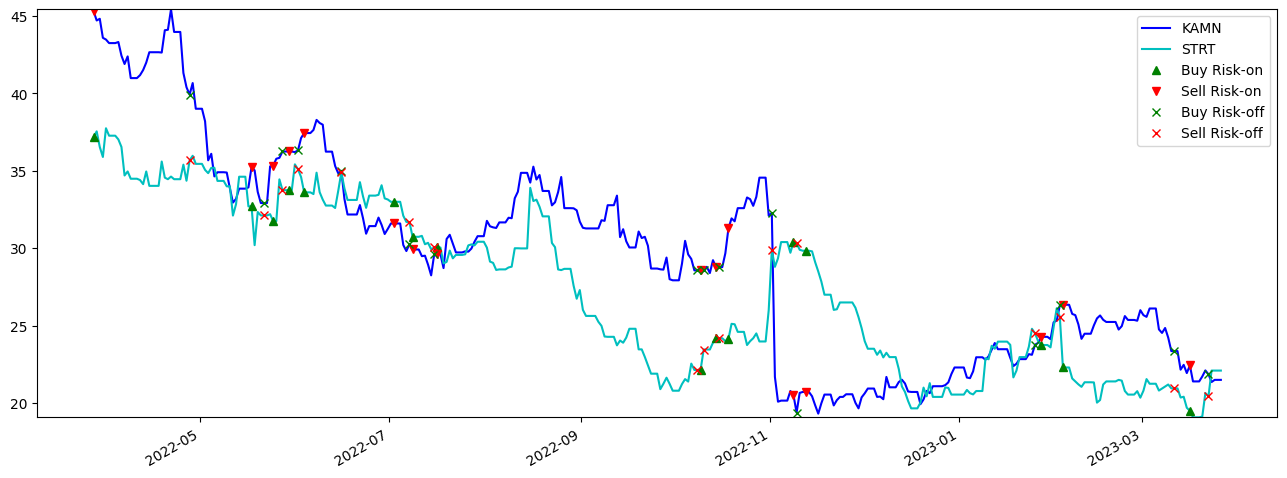

Total reward for this pair: 17.13397664066324
Total return for this pair: 20.83920544752501


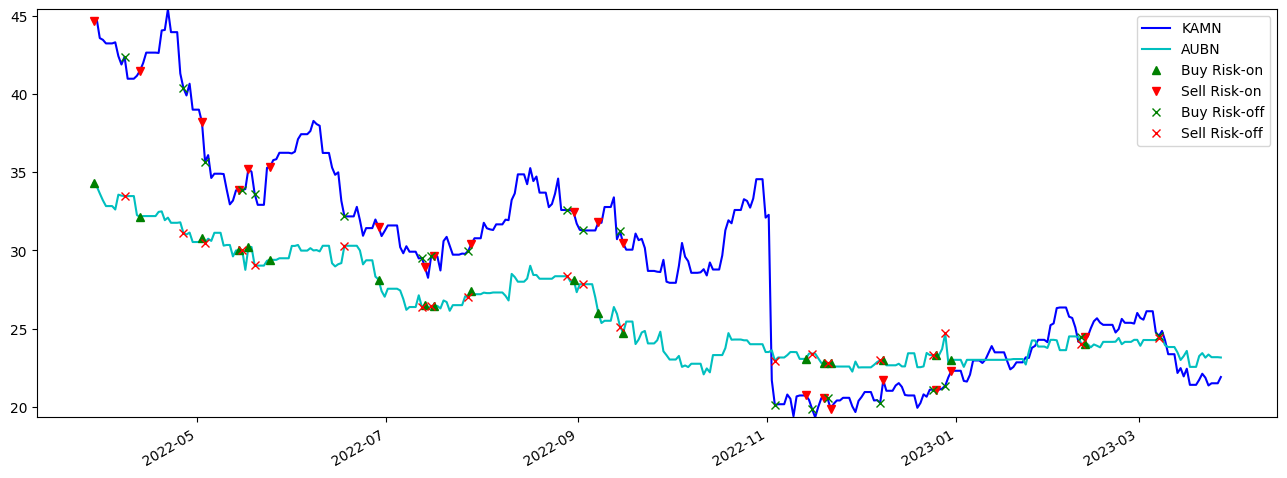

Total reward for this pair: 14.626632568649635
Total return for this pair: 16.44554615717897


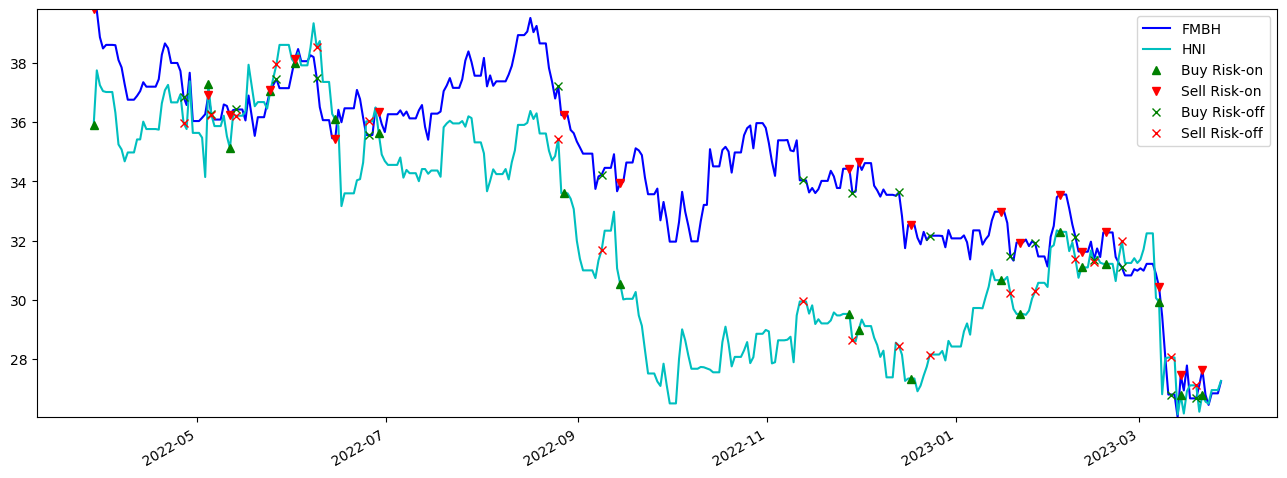

Total reward for this pair: 13.11372676901478
Total return for this pair: 15.188515550700224


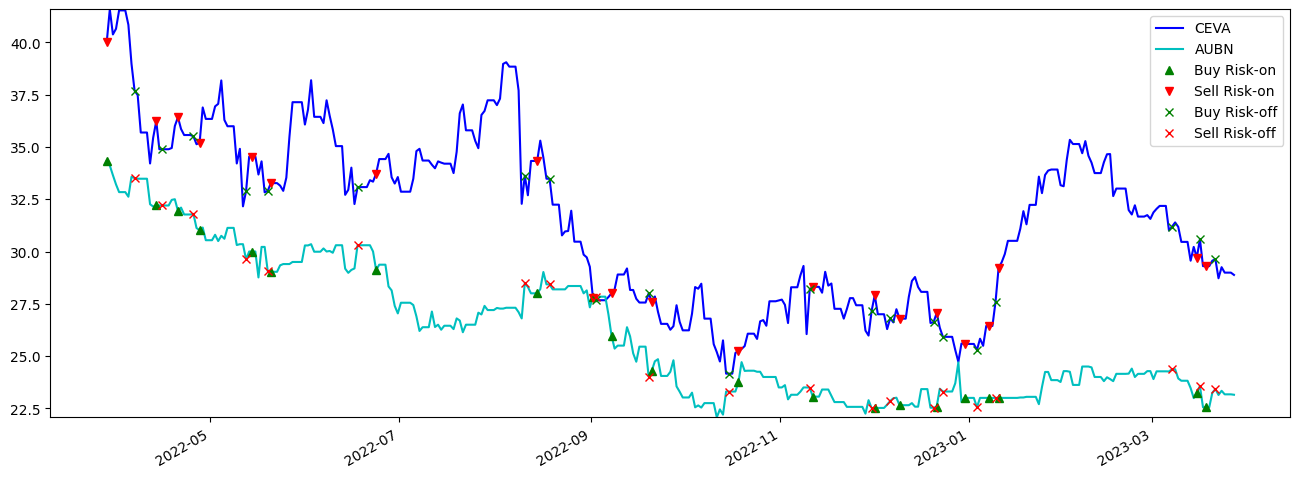

Total reward for this pair: 11.657405142768784
Total return for this pair: 14.37841007031184


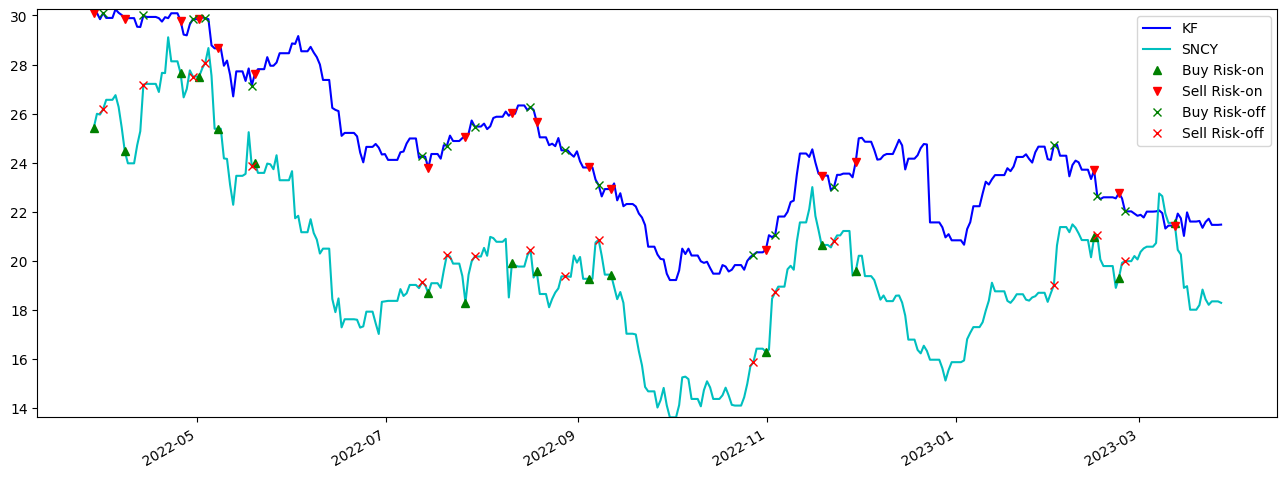

Total reward for this pair: 16.867402309917225
Total return for this pair: 18.77509075668076


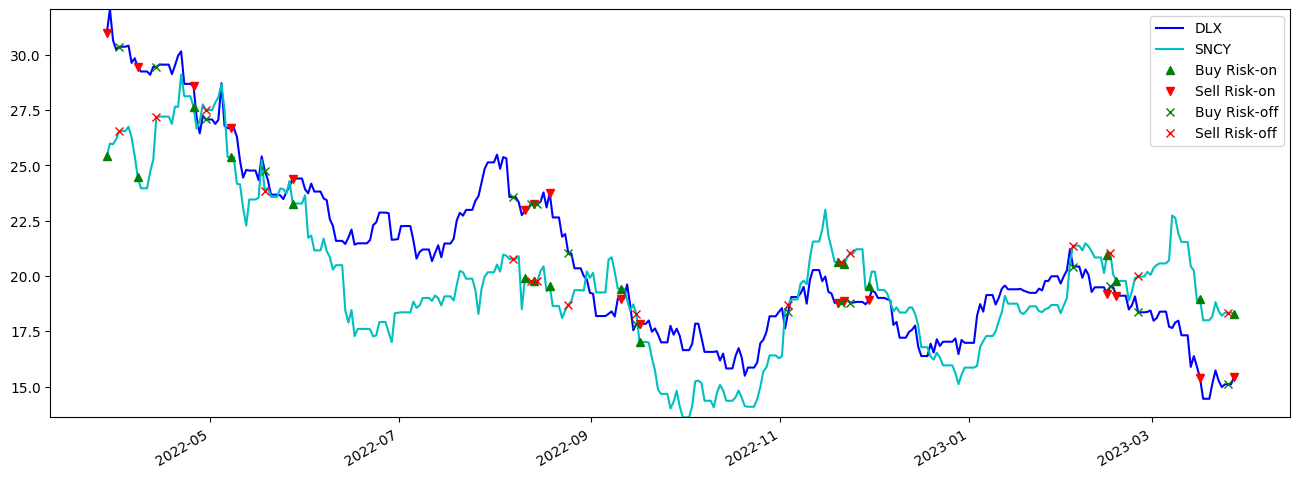

Total reward for this pair: 21.97757264150056
Total return for this pair: 23.20160608963635


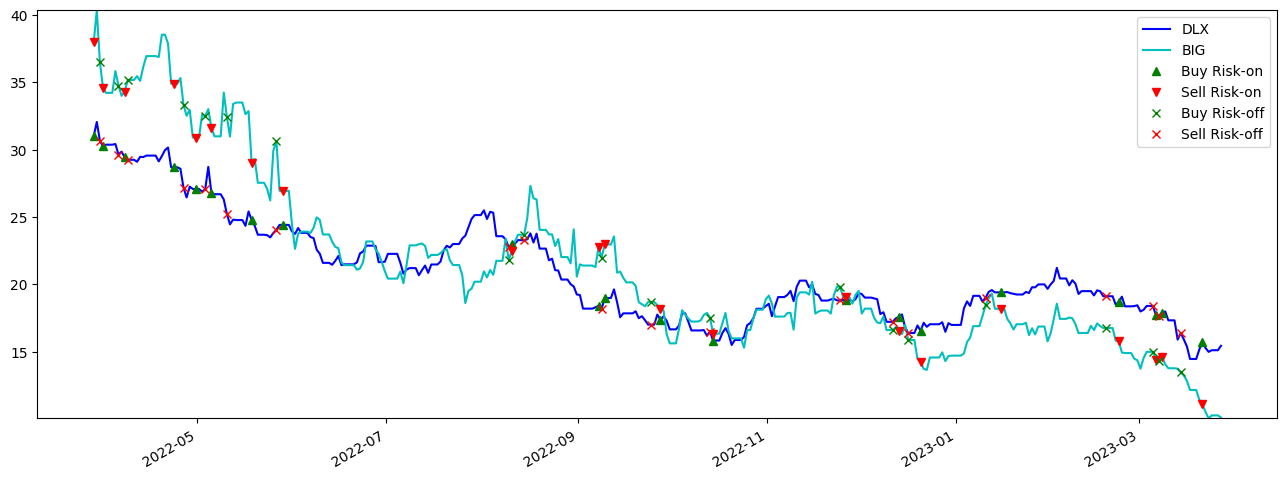

Total reward for this pair: -16.981419327482648
Total return for this pair: -14.374069853893552


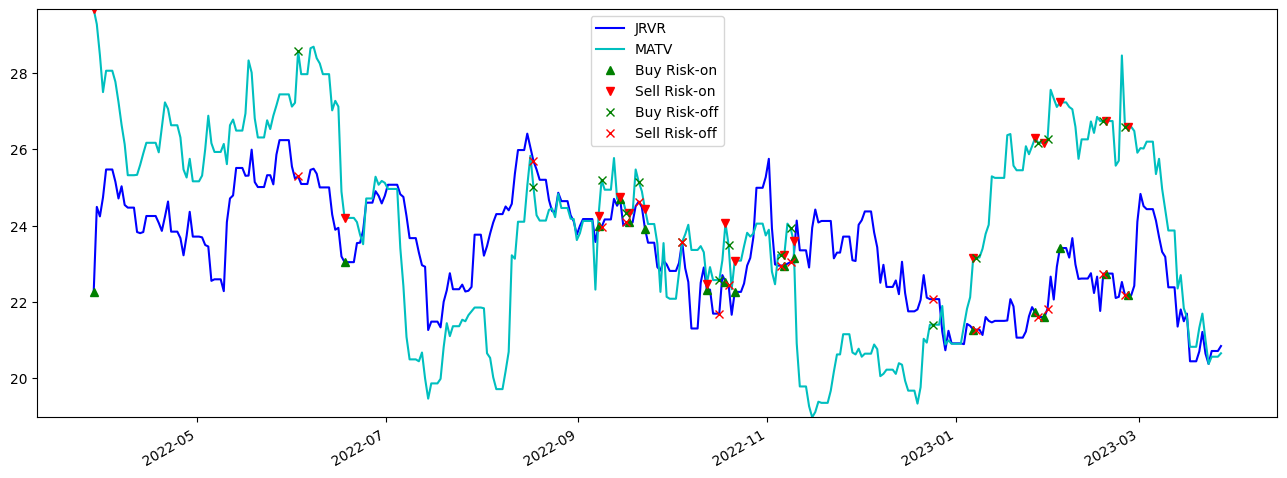

Total reward for this pair: -9.336627188972079
Total return for this pair: -7.643710077668197


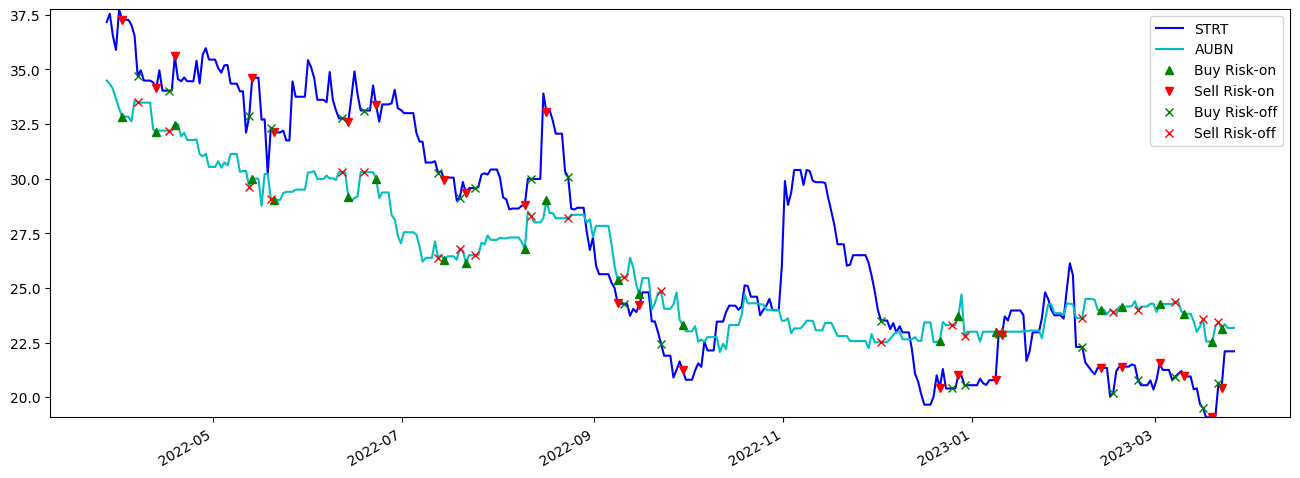

Total reward for this pair: 27.40892385691679
Total return for this pair: 30.558978071006383


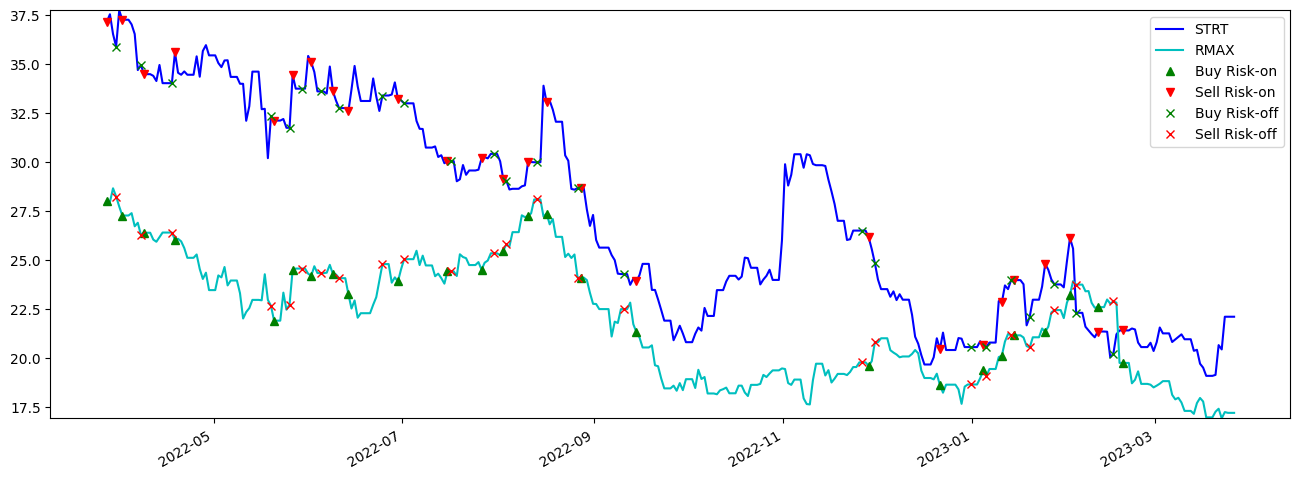

Total reward for this pair: 25.059444073643448
Total return for this pair: 29.73847557208119


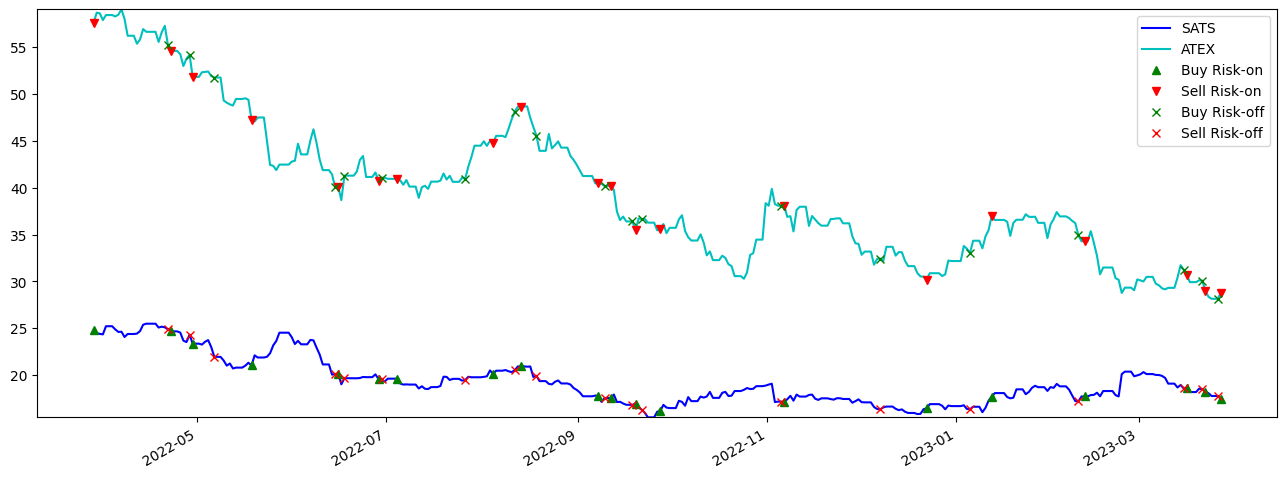

Total reward for this pair: -10.949908244675447
Total return for this pair: -9.125784464064754
Average overall rewards: 2.4121164208582124
Average overall returns: 4.7884580380143005


In [634]:
###plot###
#fill in latest model
policy_net.load_state_dict(torch.load('./models/model (31).pth'))
#policy_net.load_state_dict(torch.load('./models/model (63)_300eps.pth'))
target_net.load_state_dict(policy_net.state_dict())
policy_net.eval()   #changes forward(); disables Dropout, BatchNorm, etc.
target_net.eval()

total_rewards = []
total_returns = []
with torch.no_grad():
    for valenv in valenvs:
        obs = valenv.reset()
        state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
        for t in count():   #keep looping until done -> break
            # Select and perform an action
            action = policy_net(state).max(1)[1].view(1, 1)
            obs, _reward, done, info, _return = valenv.step(Positions(action.item()))
            state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            
            if done:
                valenv.render()   #only rendering the last year
                #total_returns.append(returns)   ###changed###
                #total_returns.append(np.sum(returns))   ###changed###
                print(f"Total reward for this pair: {info['total_reward']}")
                print(f"Total return for this pair: {info['total_return']}")
                total_rewards.append(info['total_reward'])
                total_returns.append(info['total_return'])
                break

#avg_returns = np.mean(returns)
print(f'Average overall rewards: {np.mean(total_rewards)}')
print(f'Average overall returns: {np.mean(total_returns)}')

plt.ioff()
plt.show()

In [628]:
val_return_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [608]:
len(val_reward_dict[4])

16505

In [515]:
def plot_episodes(data_dict):
    # Convert dictionary to a Pandas DataFrame
    df = pd.DataFrame.from_dict(data_dict, orient='columns').astype(float)

    #Plot all reward/return across all the paths and episodes
    sns.lineplot(data=df, dashes=False, legend=False)
    
    # Set the plot title and axis labels
    plt.suptitle('Trendlines showing trends')
    plt.xlabel('Steps in each episode')
    plt.show()


    # Calculate the (means) cumsum for each column
    #means = df.mean()
    cumsum = df.cumsum()
    
    # get the index of the column with the highest cumulative sum
    highest_cumulative_sum = cumsum.sum().idxmax()

    #print("Column with highest cumulative sum:", highest_cumulative_sum)

    #Plot all cumulative sums
    sns.lineplot(data=cumsum, legend=False, dashes=False)#, palette=['pink'], dashes=False, legend=False)
    
    # Set the plot title and axis labels
    plt.suptitle('Trendline showing change in cumulative returns across episodes')
    plt.xlabel('Steps in each episode')
    plt.ylabel('Cumulative return')
    plt.show()


    #Plot the highest cumulative sum only
    sns.lineplot(data=cumsum[highest_cumulative_sum], legend=False)#, palette=['pink'], dashes=False, legend=False)

    # Set the plot title and axis labels
    plt.suptitle('Trendline showing cumulative returns in the highest-return episode')
    plt.xlabel('Steps in the episode')
    plt.ylabel('Cumulative return')

    # Display the plot
    plt.show()
    print(f'Higest cumumlative return in epoch {highest_cumulative_sum}.')

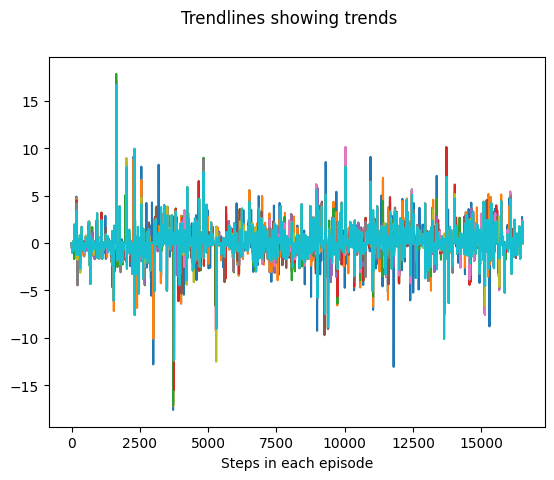

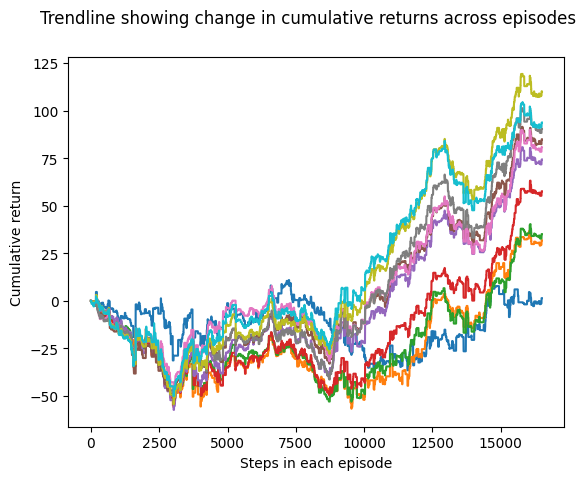

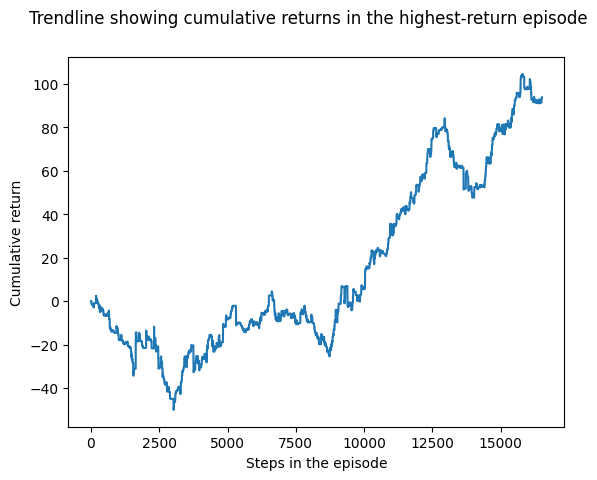

Higest cumumlative return in epoch 9.


In [635]:
plot_episodes(val_return_dict)

In [470]:
def plot_episodes(data_dict):
    # Convert dictionary to a Pandas DataFrame
    #df = pd.DataFrame.from_dict(data_dict, orient='columns')

    '''# Set the index of the DataFrame to the range of values n
    df.index = range(len(df))

    # Plot the data as a single line plot using Seaborn
    sns.lineplot(data=df)

    # Set the plot title and axis labels
    plt.title('Line plot of dictionary data')
    plt.xlabel('n')
    plt.ylabel('Values')

    # Display the plot
    plt.show()'''

    # Convert dictionary to a Pandas DataFrame
    df = pd.DataFrame.from_dict(data_dict, orient='columns').astype(float)
    #df['hue'] = range(1, len(df)+1)

    # Convert the data to long-form using melt()
    #df_long = pd.melt(df, id_vars=[0,1,2,3,4], var_name='variable', value_name='value')

    #for col in df.columns[0:5]:
    #    sns.lineplot(data=df_long[col], hue='value')
    
    # Plot the data as a line plot with trendlines using Seaborn
    #sns.lineplot(data=df_long, x='value', y=df_long.iloc[:,0:5], hue='variable')
    
    #this works
    sns.lineplot(data=df, palette=['blue'], dashes=False, legend=False)
    #sns.lineplot(data=df.iloc[:,-2:], dashes=False)
    
    
    # Melt the DataFrame to convert it to long format
    #df_melted = pd.melt(df, var_name='key', value_name='value').assign(value=lambda x: x['value'].to_numpy())

    # Plot the data as a line plot with trendlines using Seaborn
    #sns.lmplot(x=np.arange(len(df_melted)), y='value', data=df_melted)
    #sns.lineplot(x=np.arange(len(df)), y=df[0], data=df)
    #sns.lineplot(data=df.iloc[:,:5], hue='hue')

    # Set the plot title and axis labels
    plt.suptitle('Trendlines showing trends')
    plt.xlabel('n')
    #plt.ylabel('Values')

    # Display the plot
    plt.show()


    # Calculate the means for each column
    #means = df.mean()
    cumsum = df.cumsum()
    
    # get the index of the column with the highest cumulative sum
    highest_cumulative_sum = cumsum.sum().idxmax()

    print("Column with highest cumulative sum:", highest_cumulative_sum)

    # Plot the means as a line plot using Seaborn
    #sns.lineplot(data=means, color='blue')
    #Plot all cumulative sums
    sns.lineplot(data=cumsum, legend=False)#, palette=['pink'], dashes=False, legend=False)
    #Plot the highest cumulative sum only
    #sns.lineplot(data=cumsum[highest_cumulative_sum], legend=False)#, palette=['pink'], dashes=False, legend=False)

    # Set the plot title and axis labels
    plt.suptitle('Trendline showing change in cumulative returns across episodes')
    plt.xlabel('Steps in each episode')
    plt.ylabel('Cumulative return')

    # Display the plot
    plt.show()

    #Plot the highest cumulative sum only
    sns.lineplot(data=cumsum[highest_cumulative_sum], legend=False)#, palette=['pink'], dashes=False, legend=False)

    # Set the plot title and axis labels
    plt.suptitle('Trendline showing cumulative returns in the highest-return episode')
    plt.xlabel('Steps in the episode')
    plt.ylabel('Cumulative return')

    # Display the plot
    plt.show()


    #return df